In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import scipy.interpolate
import sys
import functools
from gfile_helpers import read_gfile, write_gfile, plot_gfile
import time as pytime
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
from backend import jnp, conditional_decorator, jit, use_jax, fori_loop, put, cross, dot, sign, pressfun, iotafun
from backend import get_needed_derivatives, unpack_x, rms, jacfwd, jacrev

from zernike import ZernikeTransform, get_zern_basis_idx_dense, get_double_four_basis_idx_dense, axis_posn, symmetric_x
from zernike import fringe_to_lm, lm_to_fringe, zern, zern_radial
from init_guess import get_initial_guess_scale_bdry
from boundary_conditions import compute_bc_err_four, compute_bc_err_RZ, compute_lambda_err
from plotting import plot_IC, plot_fb_err, plot_coord_surfaces, plot_coeffs
from equilibrium_dynamics import compute_accel_error_spectral
from force_balance import compute_force_error_nodes


Using JAX float64


/home/fouriest/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
# rcParams['axes.prop_cycle'] =  color_cycle
rcParams['axes.prop_cycle'] =  color_cycle + dash_cycle

labelsize=10
ticksize=8

In [5]:
class ZernikeTransform():
    """Zernike Transform (really a Fourier-Zernike, but whatever)
    
    Args:
        nodes (ndarray, shape(3,N)): nodes where basis functions are evaluated. 
            First index is (rho,theta,phi), 2nd index is node number
        mode_idx (ndarray of int, shape(Nc,3)): mode numbers for spectral basis. each row is one basis function with 
            modes (l,m,n)
        NFP (int): number of field periods   
        derivatives (array-like, shape(n,3)): orders of derivatives to compute in rho,theta,zeta.
            Each row of the array should contain 3 elements corresponding to derivatives in rho,theta,zeta
    """
    def __init__(self,nodes, mode_idx,NFP,derivatives=[0,0,0]):
        # array of which l,m,n is at which column of the interpolation matrix
        self.mode_idx = mode_idx
        # array of which r,v,z is at which row of the interpolation matrix
        self.nodes = nodes
        self.NFP = NFP
        self.derivatives = np.atleast_2d(derivatives)
        self.matrices = {i:{j:{k:{} for k in range(4)} for j in range(4)} for i in range(4)}
        self._build(self.derivatives,self.mode_idx)
    
    def _build(self,derivs, mode_idx):
        for d in derivs:
            dr = d[0]
            dv = d[1]
            dz = d[2]
            self.matrices[dr][dv][dz] = jnp.stack([fourzern(self.nodes[0],self.nodes[1],self.nodes[2],
                                               lmn[0],lmn[1],lmn[2],self.NFP,dr,dv,dz) for lmn in mode_idx]).T 
            
    def expand_nodes(self,new_nodes):
        """Change the real space resolution by adding new nodes without full recompute
        
        Only computes basis at spatial nodes that aren't already in the basis
        
        Args:
            new_nodes (ndarray, side(N,3)): new node locations. each row is the location of one node (rho,theta,zeta)
        """
        
        new_nodes = jnp.atleast_2d(new_nodes)
        # first remove nodes that are no longer needed
        old_in_new = (self.nodes[:, None] == new_nodes).all(-1).any(-1)
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][old_in_new]
        self.nodes = self.nodes[old_in_new]
        
        # then add new nodes
        new_not_in_old = ~(new_nodes[:, None] == self.nodes).all(-1).any(-1)
        nodes_to_add = new_nodes[new_not_in_old]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = jnp.vstack([
                self.matrices[d[0]][d[1]][d[2]], # old
                jnp.stack([fourzern(nodes_to_add[:,0],nodes_to_add[:,1],nodes_to_add[:,2], # new
                lmn[0],lmn[1],lmn[2],self.NFP,d[0],d[1],d[2]) for lmn in self.mode_idx]).T ])
        
        # update indices
        self.nodes = np.vstack([self.nodes, nodes_to_add])
        # permute indexes so they're in the same order as the input
        permute_idx = [new_nodes.tolist().index(i) for i in self.nodes.tolist()]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][permute_idx]
        self.nodes = self.nodes[permute_idx]
        
    
    def expand_spectral_resolution(self,mode_idx_new):
        """Change the spectral resolution of the transform without full recompute
        
        Only computes modes that aren't already in the basis
        
        Args:
            mode_idx_new (ndarray of int, shape(Nc,3)): new mode numbers for spectral basis. 
                each row is one basis function with modes (l,m,n)        
        """
        
        mode_idx_new = jnp.atleast_2d(mode_idx_new)
        # first remove modes that are no longer needed
        old_in_new = (self.mode_idx[:, None] == mode_idx_new).all(-1).any(-1)
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][:,old_in_new]
        self.mode_idx = self.mode_idx[old_in_new]
        
        # then add new modes
        new_not_in_old = ~(mode_idx_new[:, None] == self.mode_idx).all(-1).any(-1)
        modes_to_add = mode_idx_new[new_not_in_old]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = jnp.hstack([
                self.matrices[d[0]][d[1]][d[2]], # old
                jnp.stack([fourzern(self.nodes[0],self.nodes[1],self.nodes[2], # new
                lmn[0],lmn[1],lmn[2],self.NFP,d[0],d[1],d[2]) for lmn in modes_to_add]).T ])
        
        # update indices
        self.mode_idx = np.vstack([self.mode_idx, modes_to_add])
        # permute indexes so they're in the same order as the input
        permute_idx = [mode_idx_new.tolist().index(i) for i in self.mode_idx.tolist()]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][:,permute_idx]
        self.mode_idx = self.mode_idx[permute_idx]
                
    def expand_derivatives(self,new_derivatives):
        """Computes new derivative matrices
        
        Args:
            new_derivatives (array-like, shape(n,3)): orders of derivatives 
                to compute in rho,theta,zeta. Each row of the array should 
                contain 3 elements corresponding to derivatives in rho,theta,zeta
        """

        new_not_in_old = (new_derivatives[:, None] == self.derivatives).all(-1).any(-1)
        derivs_to_add = new_derivatives[~new_not_in_old]
        self._build(derivs_to_add, self.mode_idx)
        self.derivatives = jnp.vstack([self.derivatives,derivs_to_add])
        
        
    @conditional_decorator(functools.partial(jit,static_argnums=(0,2,3,4)), use_jax)    
    def transform(self,c,dr,dv,dz):
        """Transform from spectral domain to physical
        
        Args:
            c (ndarray, shape(N_coeffs,)): spectral coefficients, indexed as (lm,n) flattened in row major order
            dr (int): order of radial derivative
            dv (int): order of poloidal derivative
            dz (int): order of toroidal derivative
            
        Returns:
            x (ndarray, shape(N_nodes,)): array of values of function at node locations
        """
        return jnp.matmul(self.matrices[dr][dv][dz],c)

    @conditional_decorator(functools.partial(jit,static_argnums=(0,2)), use_jax)    
    def fit(self,x,rcond=1e-6):
        """Transform from physical domain to spectral
        
        Args:
            x (ndarray, shape(N_nodes,)): values in real space at coordinates specified by self.nodes
            rcond (float): relative cutoff for singular values in least squares fit  
            
        Returns:
            c (ndarray, shape(N_coeffs,)): spectral coefficients in Fourier-Zernike basis
        """
        return jnp.linalg.lstsq(self.matrices[0][0][0],x,rcond=rcond)[0]
        

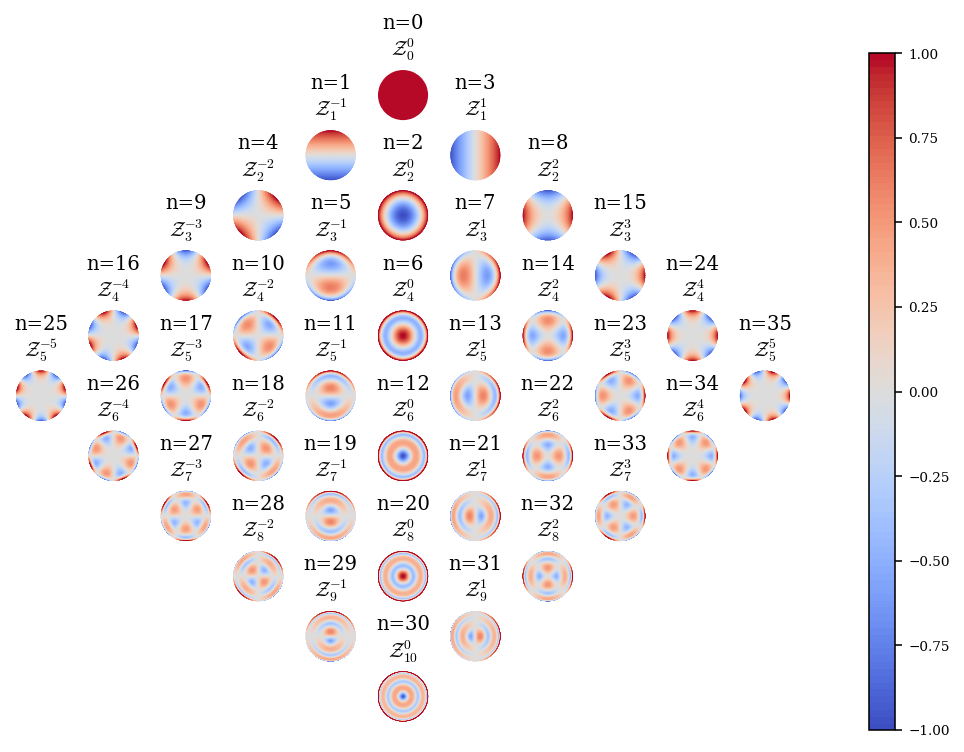

In [5]:
fig = plt.figure(figsize=(9,6))

mmax = 5
npts = 100
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
levels = np.linspace(-1,1,npts)
lmax = np.max(lm[:,0])
ax = {i:{} for i in range(lmax+1)}
gs = matplotlib.gridspec.GridSpec(lmax+1, 2*(mmax+1)) 
for l,m in lm:
    r = np.linspace(0,1,npts)
    v = np.linspace(0,2*jnp.pi,npts)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    Z = zern(rr.flatten(),vv.flatten(),l,m,0,0).reshape((npts,npts))
    
    ax[l][m] = plt.subplot(gs[l,m+mmax:m+mmax+2],projection='polar')
    ax[l][m].set_title('n=' + str(lm_to_fringe(l,m)) + '\n$\mathcal{Z}_{' + str(l) + '}^{' + str(m) + '}$')
    ax[l][m].axis('off')
    im = ax[l][m].contourf(v,r,Z,levels=levels,cmap='coolwarm')
#     ax[l][m].plot(v,jnp.ones_like(v),lw=2,c='k')

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.subplots_adjust(right=.8)
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(-1, 1, 9))

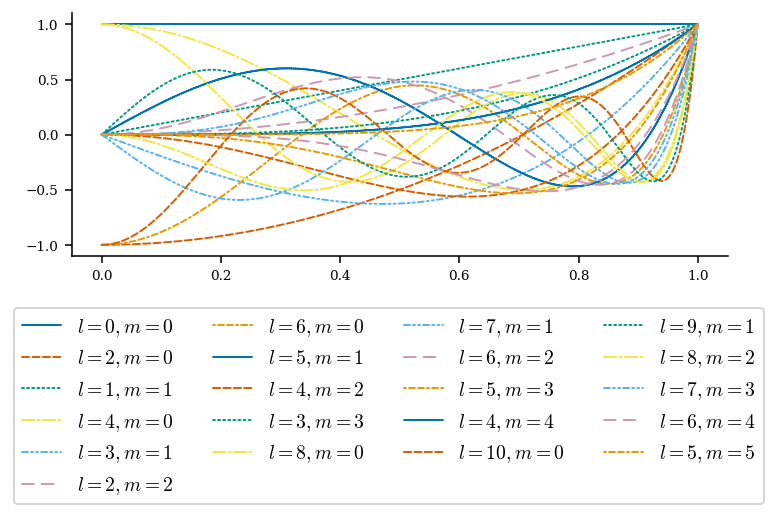

In [6]:
fig, ax = plt.subplots()

mmax = 5
npts = 1000
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
r = np.linspace(0,1,npts)

for l,m in lm:
    if (l-m)%2 == 0 and m>=0:
        ax.plot(r,zern_radial(r,l,m),lw=1,label='$l={},m={}$'.format(l,m))
plt.subplots_adjust(bottom=.45)
fig.legend(ncol=4, loc='lower center',)

In [7]:
@conditional_decorator(functools.partial(jit,static_argnums=(2)), use_jax)
def compute_coordinate_derivatives(cR,cZ,zernt):
    """Converts from spectral to real space and evaluates derivatives of R,Z wrt to SFL coords
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zernt (ZernikeTransform): object with transform method to go from spectral to physical space with derivatives
    
    Returns:
        coord_der (dict): dictionary of ndarray, shape(N_nodes,) of coordinate derivatives evaluated at node locations
    """
    # notation: X_y means derivative of X wrt y
    coord_der = {}
    coord_der['R'] = zernt.transform(cR,0,0,0)
    coord_der['Z'] = zernt.transform(cZ,0,0,0)
    coord_der['0'] = jnp.zeros_like(coord_der['R'])
    
    coord_der['R_r'] = zernt.transform(cR,1,0,0)
    coord_der['Z_r'] = zernt.transform(cZ,1,0,0)
    coord_der['R_v'] = zernt.transform(cR,0,1,0)
    coord_der['Z_v'] = zernt.transform(cZ,0,1,0)
    coord_der['R_z'] = zernt.transform(cR,0,0,1)
    coord_der['Z_z'] = zernt.transform(cZ,0,0,1)

    coord_der['R_rr'] = zernt.transform(cR,2,0,0)
    coord_der['Z_rr'] = zernt.transform(cZ,2,0,0)
    coord_der['R_rv'] = zernt.transform(cR,1,1,0)
    coord_der['Z_rv'] = zernt.transform(cZ,1,1,0)
    coord_der['R_rz'] = zernt.transform(cR,1,0,1)
    coord_der['Z_rz'] = zernt.transform(cZ,1,0,1)

    coord_der['R_vr'] = zernt.transform(cR,1,1,0)
    coord_der['Z_vr'] = zernt.transform(cZ,1,1,0)
    coord_der['R_vv'] = zernt.transform(cR,0,2,0)
    coord_der['Z_vv'] = zernt.transform(cZ,0,2,0)
    coord_der['R_vz'] = zernt.transform(cR,0,1,1)
    coord_der['Z_vz'] = zernt.transform(cZ,0,1,1)

    coord_der['R_zr'] = zernt.transform(cR,1,0,1)
    coord_der['Z_zr'] = zernt.transform(cZ,1,0,1)
    coord_der['R_zv'] = zernt.transform(cR,0,1,1)
    coord_der['Z_zv'] = zernt.transform(cZ,0,1,1)
    coord_der['R_zz'] = zernt.transform(cR,0,0,2)
    coord_der['Z_zz'] = zernt.transform(cZ,0,0,2)

    coord_der['R_rrv'] = zernt.transform(cR,2,1,0)
    coord_der['Z_rrv'] = zernt.transform(cZ,2,1,0)
    coord_der['R_rvv'] = zernt.transform(cR,1,2,0)
    coord_der['Z_rvv'] = zernt.transform(cZ,1,2,0)
    coord_der['R_zrv'] = zernt.transform(cR,1,1,1)
    coord_der['Z_zrv'] = zernt.transform(cZ,1,1,1)

    coord_der['R_rrvv'] = zernt.transform(cR,2,2,0)
    coord_der['Z_rrvv'] = zernt.transform(cZ,2,2,0)

    return coord_der

In [8]:
@conditional_decorator(functools.partial(jit), use_jax)
def compute_covariant_basis(coord_der):
    """Computes covariant basis vectors at grid points
    
    Args:
        coord_der (dict): dictionary of ndarray, shape(N_nodes,) of the coordinate derivatives at each node
        
    Returns:
        cov_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node
    """
    # notation: subscript word is direction of unit vector, subscript letters denote partial derivatives
    # eg, e_rho_v is the v derivative of the covariant basis vector in the rho direction
    cov_basis = {}
    cov_basis['e_rho']      = jnp.array([coord_der['R_r'],  coord_der['0'],   coord_der['Z_r']])
    cov_basis['e_theta']    = jnp.array([coord_der['R_v'],  coord_der['0'],   coord_der['Z_v']])
    cov_basis['e_zeta']     = jnp.array([coord_der['R_z'], -coord_der['R'],   coord_der['Z_z']])

    cov_basis['e_rho_r']    = jnp.array([coord_der['R_rr'], coord_der['0'],   coord_der['Z_rr']])
    cov_basis['e_rho_v']    = jnp.array([coord_der['R_rv'], coord_der['0'],   coord_der['Z_rv']])
    cov_basis['e_rho_z']    = jnp.array([coord_der['R_rz'], coord_der['0'],   coord_der['Z_rz']])

    cov_basis['e_theta_r']  = jnp.array([coord_der['R_vr'], coord_der['0'],   coord_der['Z_vr']])
    cov_basis['e_theta_v']  = jnp.array([coord_der['R_vv'], coord_der['0'],   coord_der['Z_vv']])
    cov_basis['e_theta_z']  = jnp.array([coord_der['R_vz'], coord_der['0'],   coord_der['Z_vz']])

    cov_basis['e_zeta_r']  = jnp.array([coord_der['R_zr'], -coord_der['R_r'], coord_der['Z_zr']])
    cov_basis['e_zeta_v']  = jnp.array([coord_der['R_zv'], -coord_der['R_v'], coord_der['Z_zv']])
    cov_basis['e_zeta_z']  = jnp.array([coord_der['R_zz'], -coord_der['R_z'], coord_der['Z_zz']])

    cov_basis['e_rho_vv']  = jnp.array([coord_der['R_rvv'], coord_der['0'],   coord_der['Z_rvv']])
    cov_basis['e_rho_vz']  = jnp.array([coord_der['R_zrv'], coord_der['0'],   coord_der['Z_zrv']])
    cov_basis['e_zeta_rv'] = jnp.array([coord_der['R_zrv'],-coord_der['R_rv'],coord_der['Z_zrv']])
    
    return cov_basis

In [9]:
@conditional_decorator(functools.partial(jit), use_jax)
def compute_jacobian(coord_der,cov_basis):
    """Computes coordinate jacobian and derivatives
    
    Args:
        coord_der (dict): dictionary of ndarray, shape(N_nodes,) of coordinate derivatives evaluated at node locations
        cov_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node 
        
    Returns:
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
    """
    # notation: subscripts denote partial derivatives
    jacobian = {}    
    jacobian['g'] = dot(cov_basis['e_rho'] , cross(cov_basis['e_theta'],cov_basis['e_zeta'],0),0)

    jacobian['g_r'] = dot(cov_basis['e_rho_r'],cross(cov_basis['e_theta'],cov_basis['e_zeta'],0),0) \
                      + dot(cov_basis['e_rho'],cross(cov_basis['e_rho_v'],cov_basis['e_zeta'],0),0) \
                      + dot(cov_basis['e_rho'],cross(cov_basis['e_theta'],cov_basis['e_zeta_r'],0),0)
    jacobian['g_v'] = dot(cov_basis['e_rho_v'],cross(cov_basis['e_theta'],cov_basis['e_zeta'],0),0) \
                      + dot(cov_basis['e_rho'],cross(cov_basis['e_theta_v'],cov_basis['e_zeta'],0),0) \
                      + dot(cov_basis['e_rho'],cross(cov_basis['e_theta'],cov_basis['e_zeta_v'],0),0)
    jacobian['g_z'] = dot(cov_basis['e_rho_z'],cross(cov_basis['e_theta'],cov_basis['e_zeta'],0),0) \
                      + dot(cov_basis['e_rho'],cross(cov_basis['e_theta_z'],cov_basis['e_zeta'],0),0) \
                      + dot(cov_basis['e_rho'],cross(cov_basis['e_theta'],cov_basis['e_zeta_z'],0),0)
    # need these later for rho=0
    jacobian['g_rr']  = coord_der['R']*(coord_der['R_r']*coord_der['Z_rrv'] - coord_der['Z_r']*coord_der['R_rrv']
                                        + 2*coord_der['R_rr']*coord_der['Z_rv'] - 2*coord_der['R_rv']*coord_der['Z_rr']) \
                                        + 2*coord_der['R_r']*(coord_der['Z_rv']*coord_der['R_r'] - coord_der['R_rv']*coord_der['Z_r'])
    jacobian['g_rv']  = coord_der['R']*(coord_der['Z_rvv']*coord_der['R_r'] - coord_der['R_rvv']*coord_der['Z_r'])
    jacobian['g_zr']  = coord_der['R_z']*(coord_der['R_r']*coord_der['Z_rv'] - coord_der['R_rv']*coord_der['Z_r']) \
                                          + coord_der['R']*(coord_der['R_zr']*coord_der['Z_rv'] + coord_der['R_r']*coord_der['Z_zrv']
                                          - coord_der['R_zrv']*coord_der['Z_r'] - coord_der['R_rv']*coord_der['Z_zr'])
    jacobian['g_rrv'] = 2*coord_der['R_rv']*(coord_der['Z_rv']*coord_der['R_r'] - coord_der['R_rv']*coord_der['Z_r']) \
                            + 2*coord_der['R_r']*(coord_der['Z_rvv']*coord_der['R_r'] - coord_der['R_rvv']*coord_der['Z_r']) \
                            + coord_der['R']*(coord_der['R_r']*coord_der['Z_rrvv'] - coord_der['Z_r']*coord_der['R_rrvv']
                                              + 2*coord_der['R_rr']*coord_der['Z_rvv'] - coord_der['R_rv']*coord_der['Z_rrv']
                                              - 2*coord_der['Z_rr']*coord_der['R_rvv'] + coord_der['Z_rv']*coord_der['R_rrv'])
    for key, val in jacobian.items():
        jacobian[key] = val.flatten()
    
    return jacobian

In [10]:
@conditional_decorator(functools.partial(jit,static_argnums=(0,2,3,5)), use_jax)
def compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params):
    """Computes magnetic field at node locations
    
    Args:
        Psi_total (float): total toroidal flux within LCFS
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
        nodes (ndarray, shape(3,N_nodes)): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis
        cov_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node 
        iotafun_params (array-like): parameters to pass to rotational transform function   
    Return:
        B_field (dict): dictionary of ndarray, shape(N_nodes,) of magnetic field and derivatives
    """
    # notation: 1 letter subscripts denote derivatives, eg psi_rr = d^2 psi/dr^2
    # word sub or superscripts denote co and contravariant components of the field
    r = nodes[0]   
    iota = iotafun(r,0, iotafun_params)
    iotar = iotafun(r,1, iotafun_params)
    
    B_field = {}
    # B field
    B_field['psi'] = Psi_total*r**2 # could instead make Psi(r) an arbitrary function?
    B_field['psi_r']  = 2*Psi_total*r
    B_field['psi_rr'] = 2*Psi_total*jnp.ones_like(r)
    B_field['B^rho'] = jnp.zeros_like(r)
    B_field['B^zeta'] = B_field['psi_r'] / (2*jnp.pi*jacobian['g'])
    B_field['B^theta'] = iota * B_field['B^zeta']

    B_field['B_RphiZ'] = B_field['B^rho']*cov_basis['e_rho'] \
                        + B_field['B^theta']*cov_basis['e_theta'] \
                        + B_field['B^zeta']*cov_basis['e_zeta']
    
    
    # B^{zeta} derivatives
    B_field['B^zeta_r'] = B_field['psi_rr'] / (2*jnp.pi*jacobian['g']) - (B_field['psi_r']*jacobian['g_r']) / (2*jnp.pi*jacobian['g']**2)
    B_field['B^zeta_v'] = - (B_field['psi_r']*jacobian['g_v']) / (2*jnp.pi*jacobian['g']**2)
    B_field['B^zeta_z'] = - (B_field['psi_r']*jacobian['g_z']) / (2*jnp.pi*jacobian['g']**2)
    # rho=0 terms only
    B_field['B^zeta_rv'] = B_field['psi_rr']*(2*jacobian['g_rr']*jacobian['g_rv'] 
                                              - jacobian['g_r']*jacobian['g_rrv']) / (4*jnp.pi*jacobian['g_r']**3)

    # magnetic axis
    B_field['B^zeta'] = put(B_field['B^zeta'], axn, Psi_total / (jnp.pi*jacobian['g_r'][axn]))
    B_field['B^theta'] = put(B_field['B^theta'], axn, Psi_total*iota[axn] / (jnp.pi*jacobian['g_r'][axn]))
    B_field['B^zeta_r'] = put(B_field['B^zeta_r'], axn, -(B_field['psi_rr'][axn]*jacobian['g_rr'][axn]) / (4*jnp.pi*jacobian['g_r'][axn]**2))
    B_field['B^zeta_v'] = put(B_field['B^zeta_v'], axn, 0)
    B_field['B^zeta_z'] = put(B_field['B^zeta_z'], axn, -(B_field['psi_rr'][axn]*jacobian['g_zr'][axn]) / (2*jnp.pi*jacobian['g_r'][axn]**2))

    # covariant B-component derivatives
    B_field['B_theta_r'] = B_field['B^zeta_r']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'],cov_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iotar*cov_basis['e_theta']+iota*cov_basis['e_rho_v']
                                                    +cov_basis['e_zeta_r'],cov_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_rho_v'],0)
    
    B_field['B_zeta_r'] = B_field['B^zeta_r']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iotar*cov_basis['e_theta']+iota*cov_basis['e_rho_v']
                                                    +cov_basis['e_zeta_r'],cov_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_zeta_r'],0)
    
    B_field['B_rho_v'] = B_field['B^zeta_v']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_rho'],0) \
                        + B_field['B^zeta']*dot(iota*cov_basis['e_theta_v'] + cov_basis['e_zeta_v'], cov_basis['e_rho'],0) \
                        + B_field['B^zeta']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_rho_v'],0)
    
    B_field['B_zeta_v'] = B_field['B^zeta_v']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta_v'] + cov_basis['e_zeta_v'], cov_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_zeta_v'],0)
    
    B_field['B_rho_z'] = B_field['B^zeta_z']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_rho'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta_z'] + cov_basis['e_zeta_z'], cov_basis['e_rho'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_rho_z'],0)
    
    B_field['B_theta_z'] = B_field['B^zeta_z']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta_z'] + cov_basis['e_zeta_z'], cov_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_theta'] + cov_basis['e_zeta'], cov_basis['e_theta_z'],0)
    
    # need these later to evaluate axis terms
    B_field['B_zeta_rv'] = B_field['B^zeta_rv']*dot(cov_basis['e_zeta'],cov_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*cov_basis['e_rho_vv'] + 2*cov_basis['e_zeta_rv'], cov_basis['e_zeta'],0)
    B_field['B_theta_zr'] = B_field['B^zeta_z']*dot(cov_basis['e_zeta'],cov_basis['e_rho_v'],0) \
                            + B_field['B^zeta']*(dot(cov_basis['e_zeta_z'],cov_basis['e_rho_v'],0) 
                                                 + dot(cov_basis['e_zeta'],cov_basis['e_rho_vz'],0))

    for key, val in B_field.items():
        B_field[key] = val.flatten()

    return B_field

In [11]:
@conditional_decorator(functools.partial(jit,static_argnums=(2,3)), use_jax)
def compute_J_field(B_field, jacobian, nodes, axn):
    """Computes J from B
    (note it actually just computes curl(B), ie mu0*J)
    
    Args:
        B_field (dict): dictionary of ndarray, shape(N_nodes,) of magnetic field and derivatives    
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
        nodes (ndarray, shape(3,N_nodes)): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis
    
    Returns:
        J_field (dict): dictionary of ndarray, shape(N_nodes,) of current density vector at each node
    """
    # notation: superscript denotes contravariant component
    J_field = {}
    # contravariant J-components
    J_field['J^rho'] = (B_field['B_zeta_v'] - B_field['B_theta_z'])
    J_field['J^theta'] = (B_field['B_rho_z'] - B_field['B_zeta_r'])
    J_field['J^zeta'] = (B_field['B_theta_r'] - B_field['B_rho_v'])

    # axis terms
    J_field['J^rho'] = put(J_field['J^rho'], axn, (B_field['B_zeta_rv'][axn] - B_field['B_theta_zr'][axn]) / (jacobian['g_r'][axn]))
    
    for key, val in J_field.items():
        J_field[key] = val.flatten()
    
    return J_field

In [12]:
@conditional_decorator(functools.partial(jit,static_argnums=(3,4)), use_jax)
def compute_contravariant_basis(coord_der, cov_basis, jacobian, nodes, axn):
    """Computes contravariant basis vectors and jacobian elements
    
    Args:
        coord_der (dict): dictionary of ndarray, shape(N_nodes,) of coordinate derivatives evaluated at node locations
        cov_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node 
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
        nodes (ndarray, shape(3,N_nodes)): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis

    Returns:
        con_basis (dict): dictionary of ndarray, shape(N_nodes,) of contravariant basis vectors and jacobian elements
    
    """
    
    # notation: grad_x denotes gradient of x
    # superscript denotes contravariant component
    N_nodes = nodes[0].size
    r = nodes[0]
    
    con_basis = {}
    # contravariant basis vectors
    con_basis['grad_rho'] = cross(cov_basis['e_theta'],
                                            cov_basis['e_zeta'],0)/jacobian['g']  
    con_basis['grad_theta'] = cross(cov_basis['e_zeta'],
                                              cov_basis['e_rho'],0)/jacobian['g']  
    con_basis['grad_zeta'] = jnp.array([coord_der['0'],
                                                 -1/coord_der['R'],
                                                 coord_der['0']])

    # axis terms. need some weird indexing because we're indexing into a 2d array with 
    # a 1d array of columns where we want to overwrite stuff
    # basically this gets the linear (flattened) indices we want to overwrite
    idx0 = jnp.ones((3,axn.size))
    idx1 = jnp.ones((3,axn.size))
    idx0 = (idx0*jnp.array([[0,1,2]]).T).flatten().astype(jnp.int32)
    idx1 = (idx1*axn).flatten().astype(jnp.int32)
    con_basis['grad_rho'] = put(con_basis['grad_rho'], (idx0,idx1), 
                                          (cross(cov_basis['e_rho_v'][:,axn],
                                                 cov_basis['e_zeta'][:,axn],0) / jacobian['g_r'][axn]).flatten())
    con_basis['grad_theta'] = put(con_basis['grad_theta'], (idx0,idx1), 
                                            (cross(cov_basis['e_zeta'][:,axn],
                                                   cov_basis['e_rho'][:,axn],0)).flatten())

    # just different names for the same thing
    con_basis['e^rho'] = con_basis['grad_rho']
    con_basis['e^theta'] = con_basis['grad_theta']
    con_basis['e^zeta'] = con_basis['grad_zeta']
    # metric coefficients
    con_basis['g^rr'] = dot(con_basis['grad_rho'],con_basis['grad_rho'],0)
    con_basis['g^vv'] = dot(con_basis['grad_theta'],con_basis['grad_theta'],0)  
    con_basis['g^zz'] = dot(con_basis['grad_zeta'],con_basis['grad_zeta'],0)  
    con_basis['g^vz'] = dot(con_basis['grad_theta'],con_basis['grad_zeta'],0)   
    
    return con_basis

In [13]:
@conditional_decorator(functools.partial(jit,static_argnums=(2,3,4,5,6,7)), use_jax)
def compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume):
    """Computes force balance error at each node
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zernt (ZernikeTransform): object with tranform method to convert from spectral basis to physical basis at nodes
        pressfun_params (array-like): parameters to pass to pressure function
        iotafun_params (array-like): parameters to pass to rotational transform function
        Psi_total (float): total toroidal flux within LCFS
        node_volume (ndarray, shape(3,N_nodes)): arc length (dr,dv,dz) along each coordinate at each node, for computing volume.
        
    Returns:
        F_err (ndarray, shape(2*N_nodes,)): R,phi,Z components of force balance error at each grid point
    """
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = jnp.where(r == 0)[0]
    # value of r one step out from axis
    r1 = jnp.min(r[r != 0])
    r1idx = jnp.where(r == r1)[0]
    
    pres = pressfun(r,0,pressfun_params)
    presr = pressfun(r,1, pressfun_params)

    # compute coordinates, fields etc.
    coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
    cov_basis = compute_covariant_basis(coord_der)
    jacobian = compute_jacobian(coord_der,cov_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
    J_field = compute_J_field(B_field, jacobian, nodes, axn)
    con_basis = compute_contravariant_basis(coord_der, cov_basis, jacobian, nodes, axn)

    # helical basis vector
    beta = B_field['B^zeta']*con_basis['e^theta'] - B_field['B^theta']*con_basis['e^zeta']

    # force balance error in radial and helical direction
    Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
    Fbeta = J_field['J^rho']
    
    
    radial  = jnp.sqrt(con_basis['g^rr']) * jnp.sign(dot(con_basis['e^rho'],cov_basis['e_rho'],0));
    helical = jnp.sqrt(con_basis['g^vv']*B_field['B^zeta']**2 + con_basis['g^zz']*B_field['B^theta']**2 \
               - 2*con_basis['g^vz']*B_field['B^theta']*B_field['B^zeta']) * jnp.sign(
            dot(beta,cov_basis['e_theta'],0))*jnp.sign(dot(beta,cov_basis['e_zeta'],0));
    put(helical,axn,jnp.sqrt(con_basis['g^vv'][axn]*B_field['B^zeta'][axn]**2) * jnp.sign(B_field['B^zeta'][axn]))

    
    # weight by local volume
    if node_volume is not None:
        vol = jacobian['g']*node_volume[0]*node_volume[1]*node_volume[2];
        vol = put(vol, axn, jnp.mean(jacobian['g'][r1idx])/2*node_volume[0,axn]*node_volume[1,axn]*node_volume[2,axn])
        Frho = Frho*vol
        Fbeta = Fbeta*vol
        
    F_err = jnp.concatenate([Frho*radial,Fbeta*helical])
 
    return F_err

In [19]:
cR = cR_init
cZ = cZ_init
cL = cL_init

N_nodes = nodes[0].size
r = nodes[0]
axn = jnp.where(r == 0)[0]
# value of r one step out from axis
r1 = np.min(r[r != 0])
r1idx = np.where(r == r1)[0]

pres = pressfun(r,0,pressfun_params)
presr = pressfun(r,1, pressfun_params)

# compute coordinates, fields etc.
coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
cov_basis = compute_covariant_basis(coord_der)
jacobian = compute_jacobian(coord_der,cov_basis)
B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
J_field = compute_J_field(B_field, jacobian, nodes, axn)
con_basis = compute_contravariant_basis(coord_der, cov_basis, jacobian, nodes, axn)

# helical basis vector
beta = B_field['B^zeta']*con_basis['e^theta'] - B_field['B^theta']*con_basis['e^zeta']

# force balance error in radial and helical direction
Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
Fbeta = J_field['J^rho']

radial  = jnp.sqrt(con_basis['g^rr']) * jnp.sign(dot(con_basis['e^rho'],cov_basis['e_rho'],0));
helical = jnp.sqrt(con_basis['g^vv']*B_field['B^zeta']**2 + con_basis['g^zz']*B_field['B^theta']**2 \
               - 2*con_basis['g^vz']*B_field['B^theta']*B_field['B^zeta']) * sign(
    dot(beta,cov_basis['e_theta'],0))*sign(dot(beta,cov_basis['e_zeta'],0));
put(helical,axn,jnp.sqrt(con_basis['g^vv'][axn]*B_field['B^zeta'][axn]**2) * sign(B_field['B^zeta'][axn]))

F_err = jnp.concatenate([Frho*radial,Fbeta*helical])


# force balance error in R,phi,Z
# F_err = Frho*con_basis['grad_rho'] + Fbeta*beta

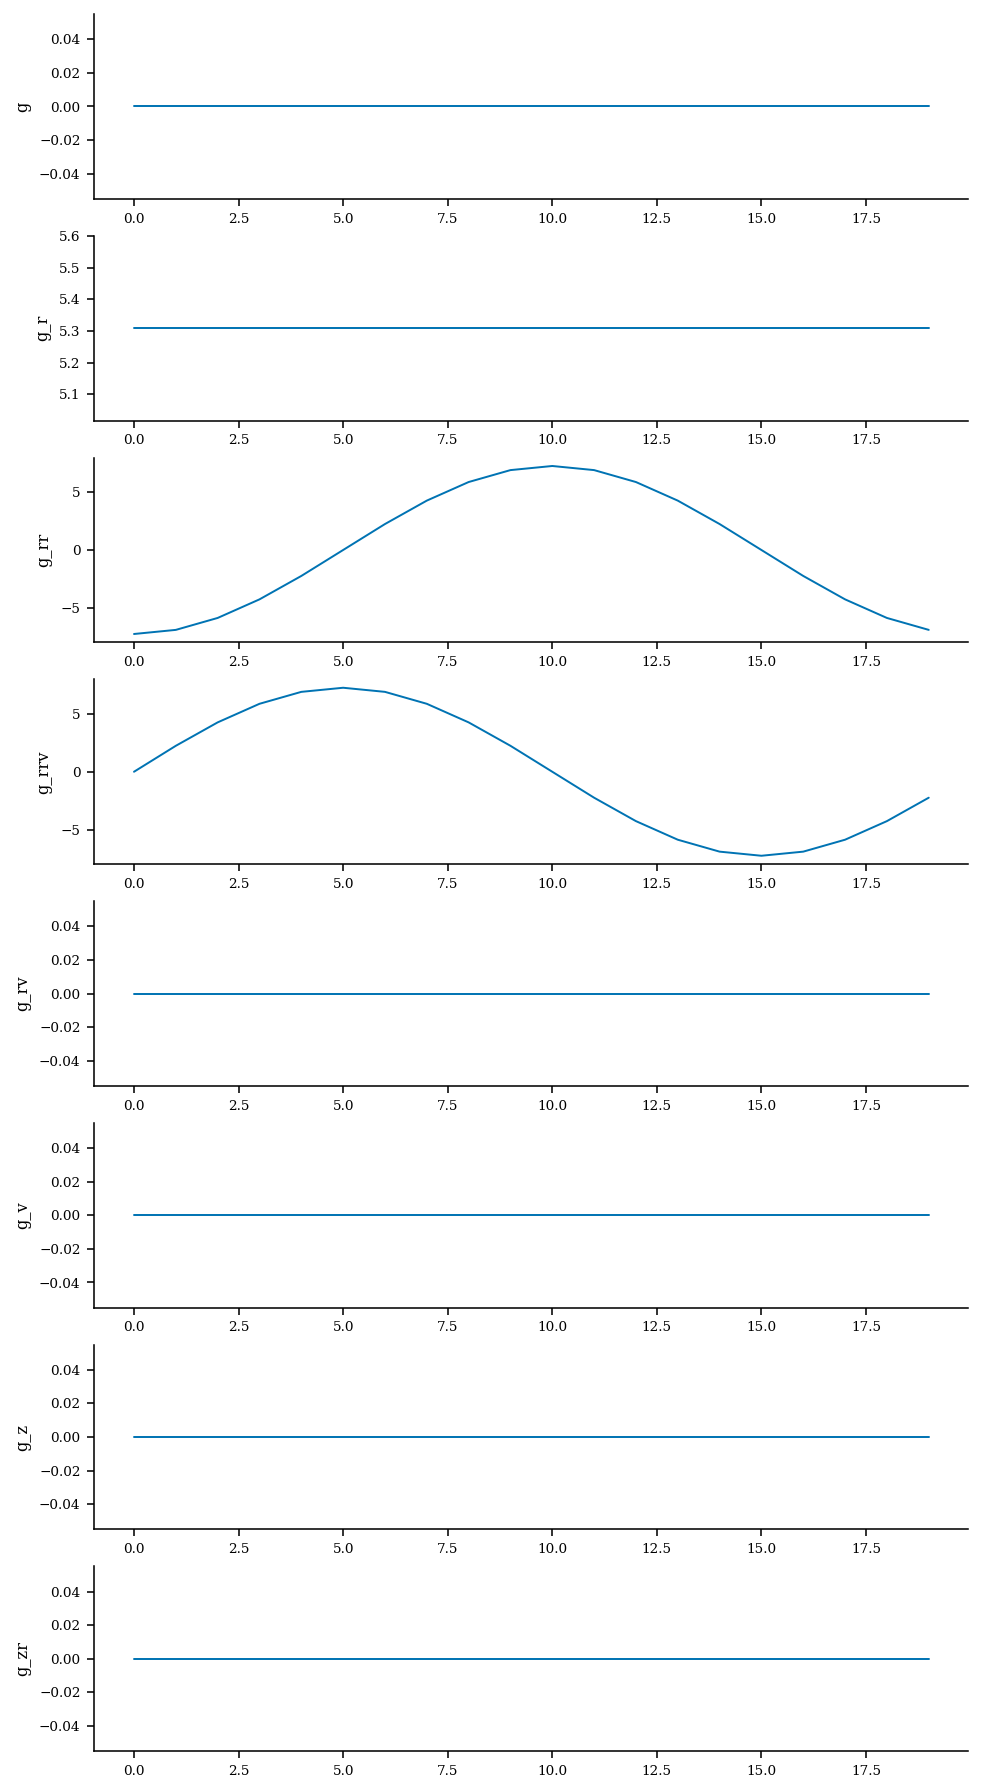

In [27]:
data = jacobian
fig, ax = plt.subplots(len(data),figsize=(8,16))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

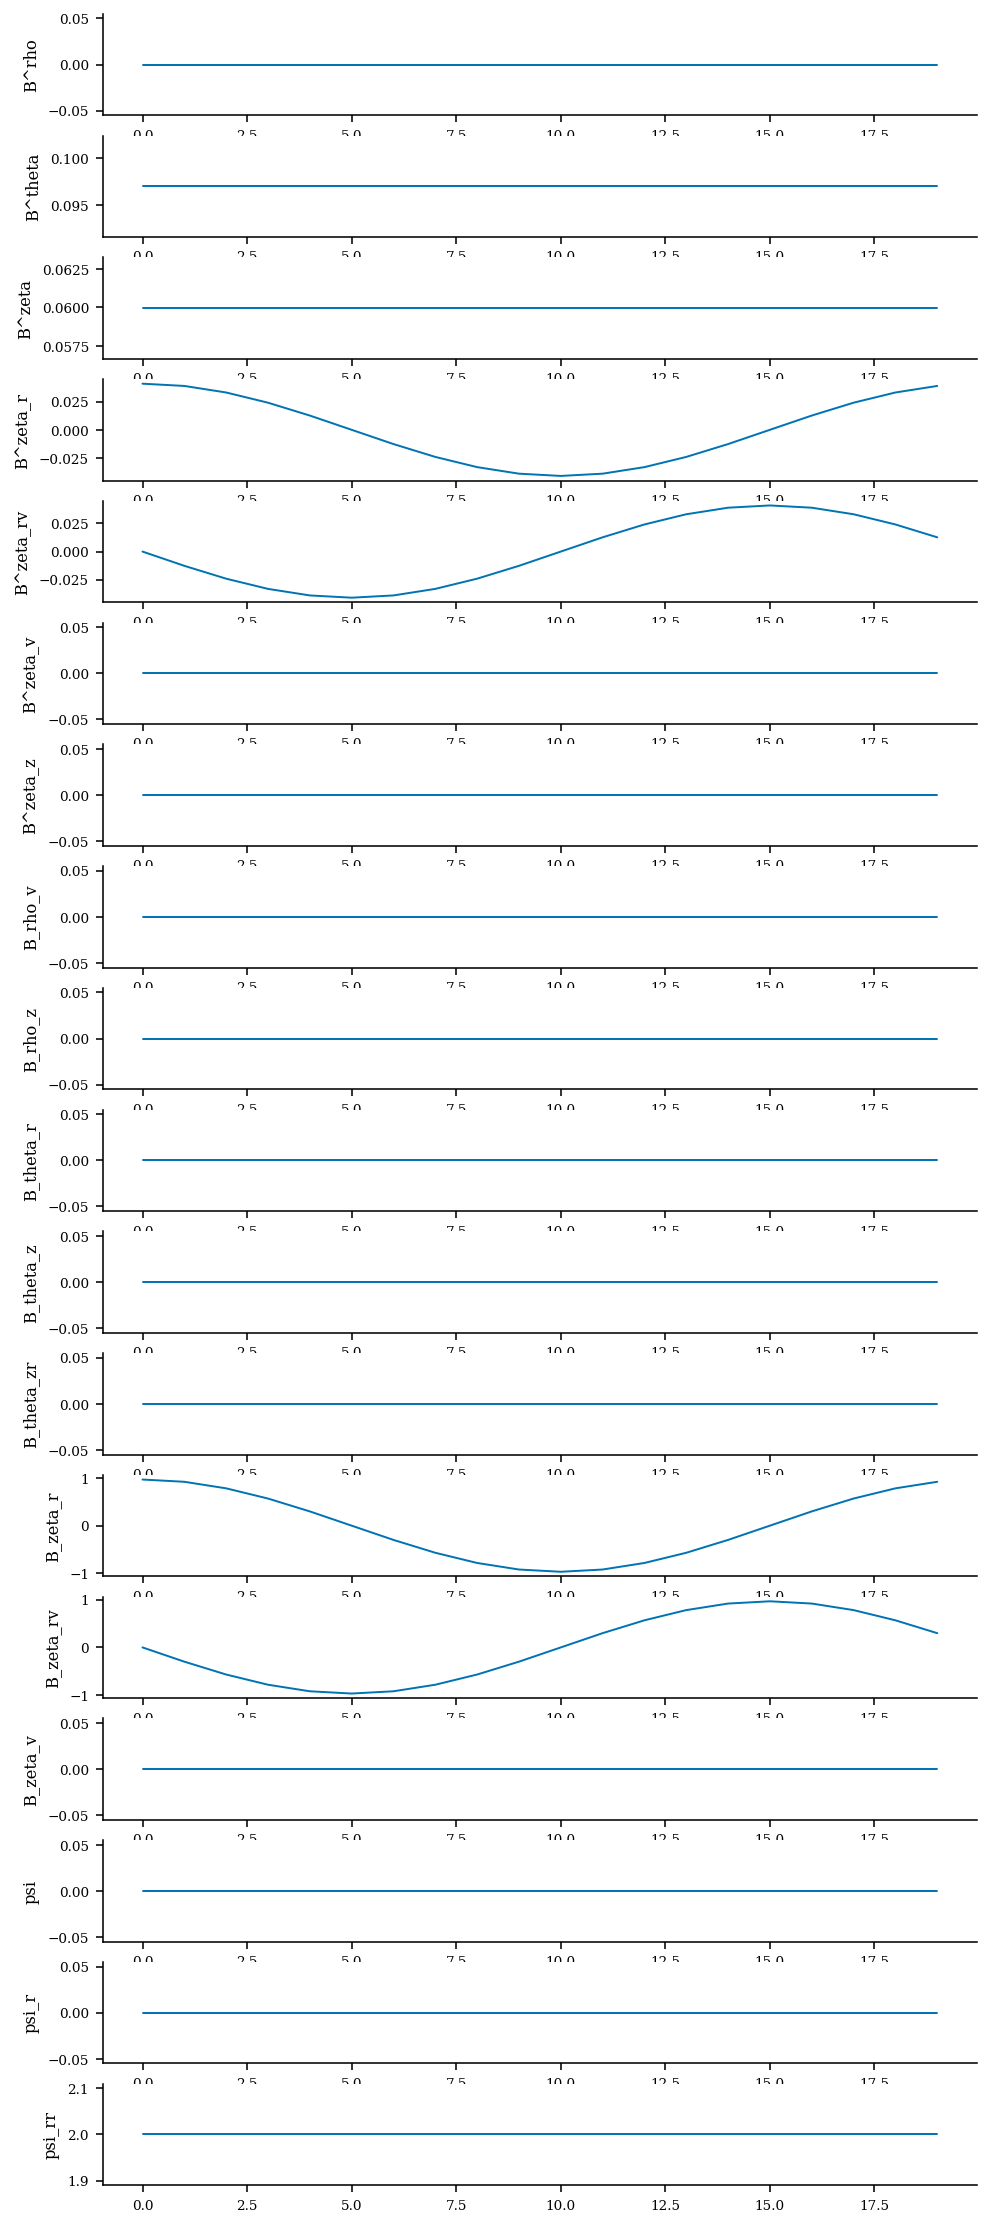

In [21]:
data = B_field
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

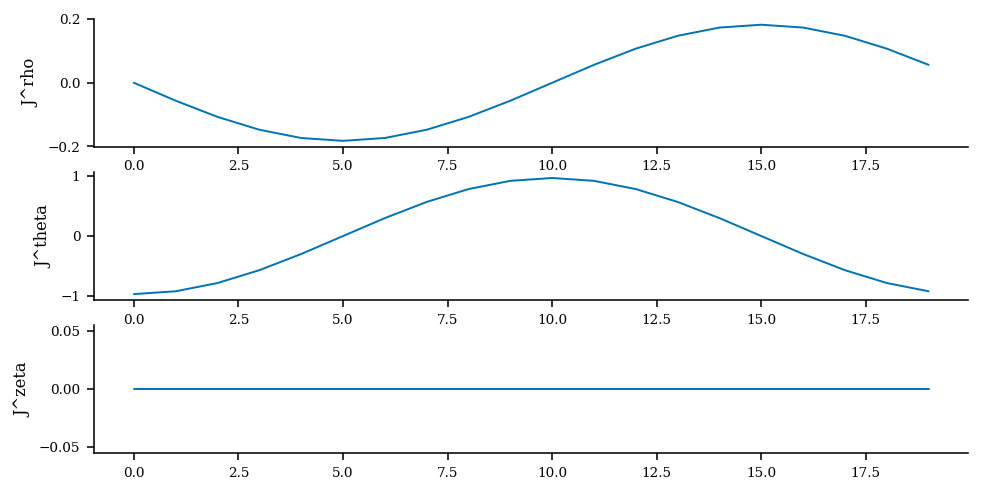

In [28]:
data = J_field
fig, ax = plt.subplots(len(data),figsize=(8,4))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

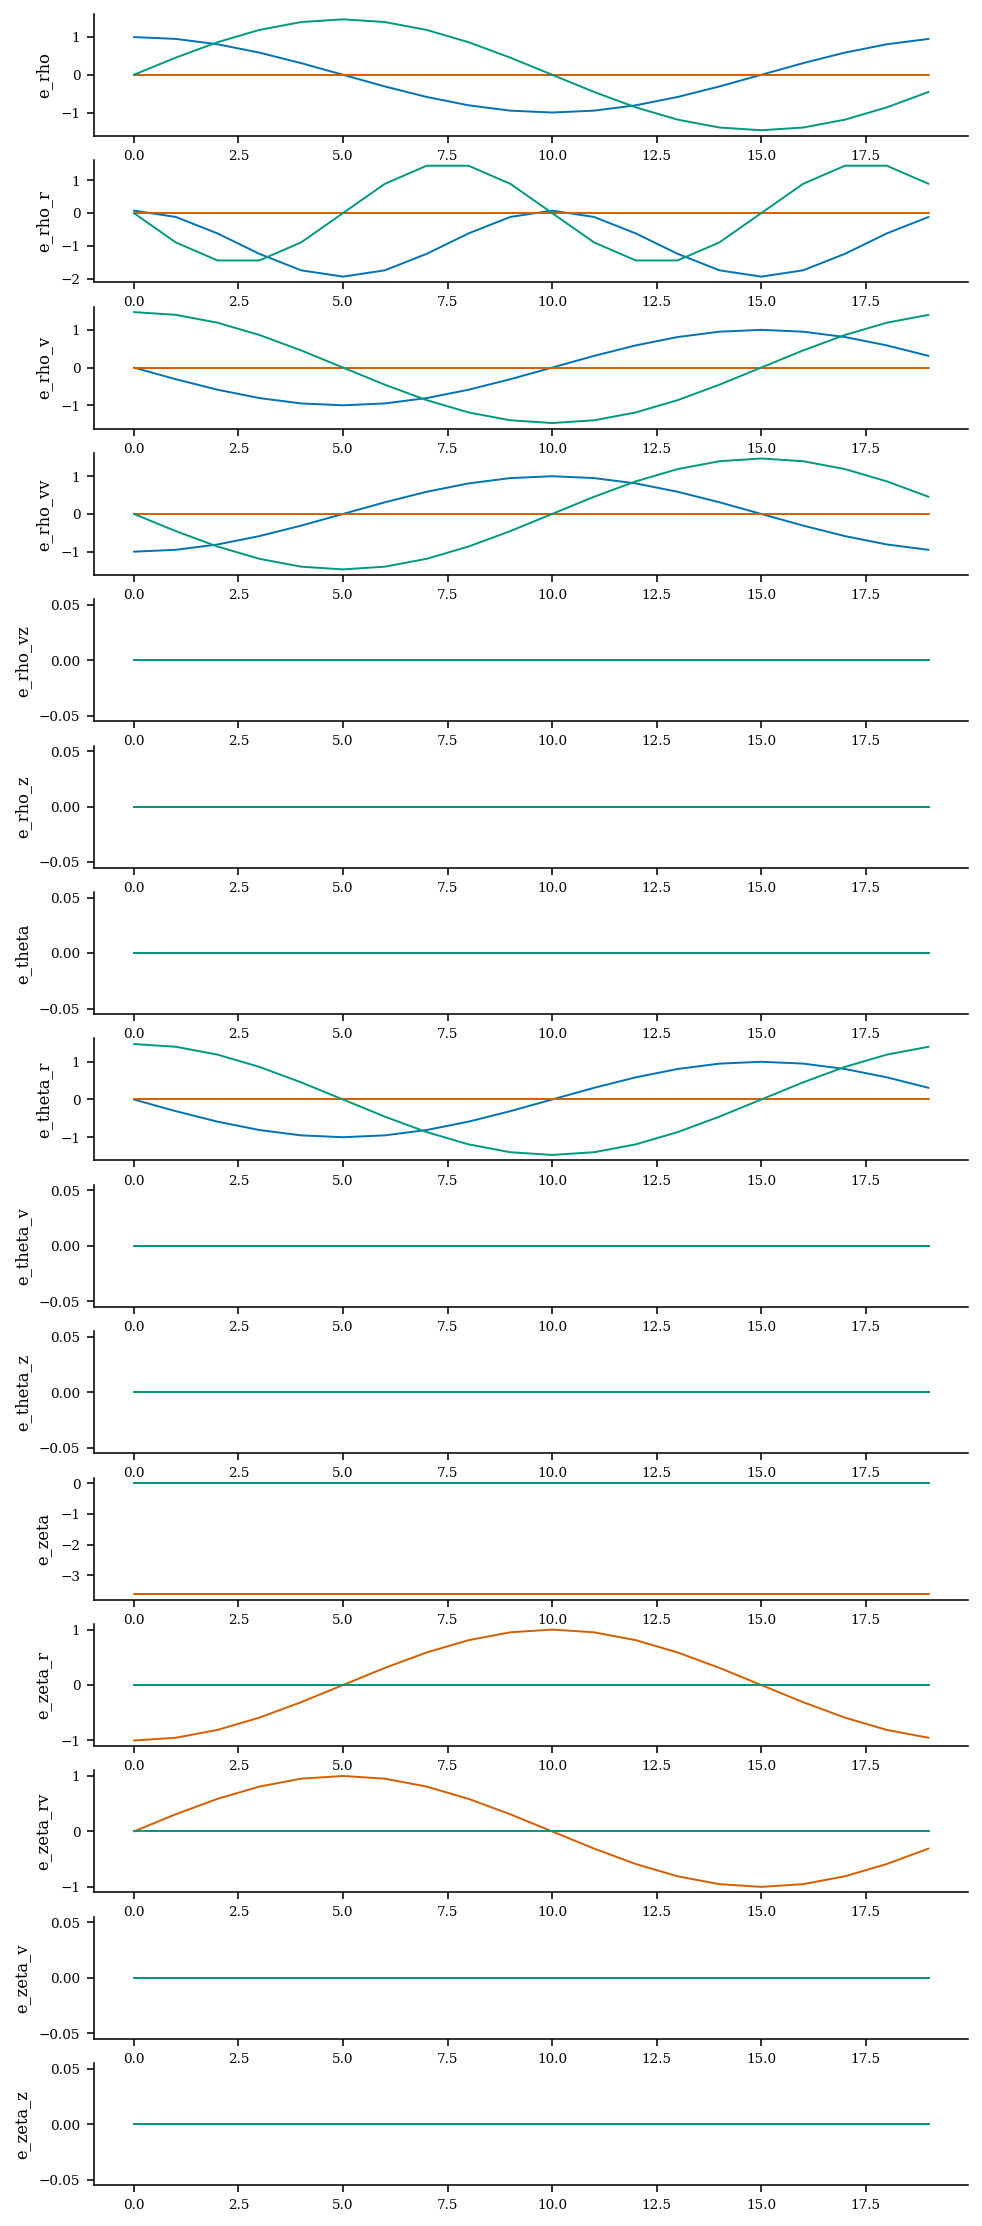

In [23]:
data = cov_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

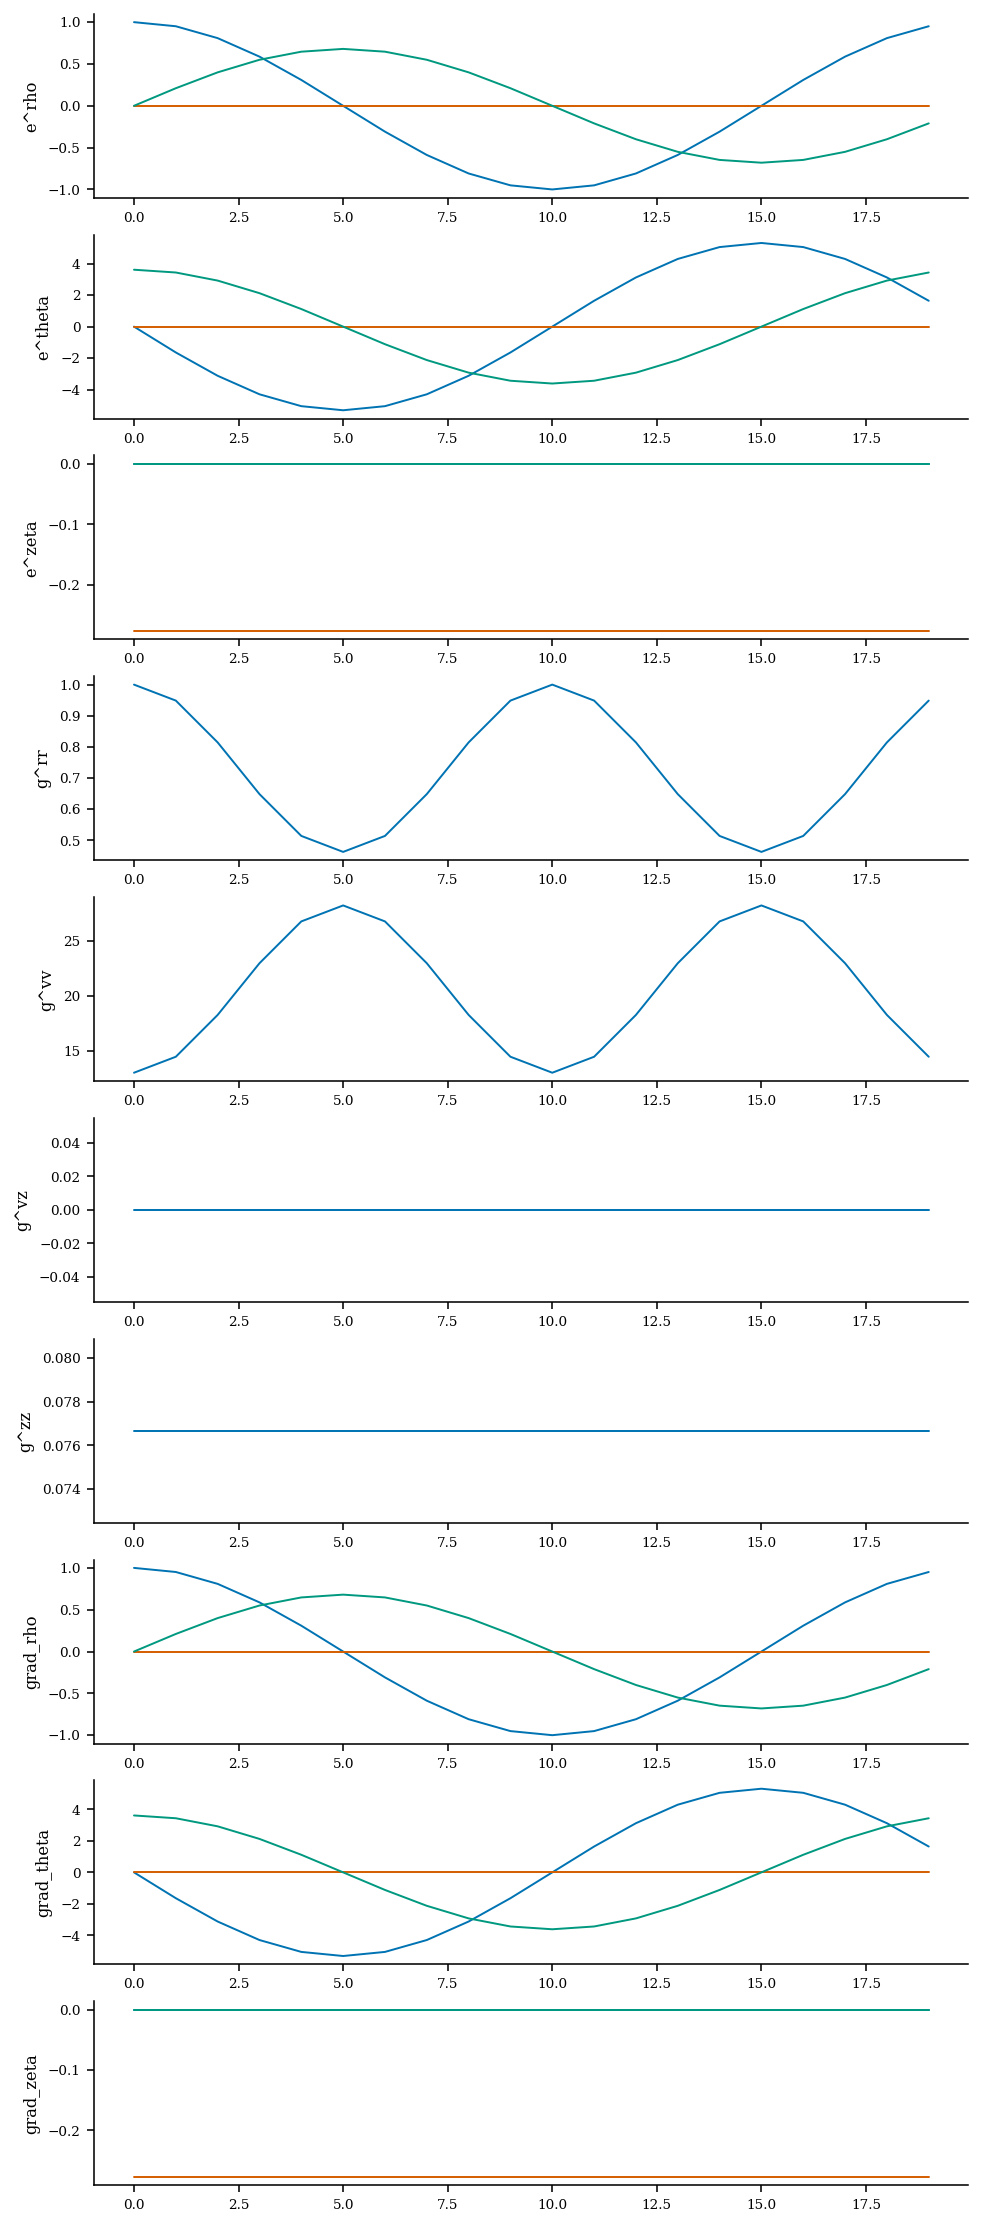

In [24]:
data = con_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

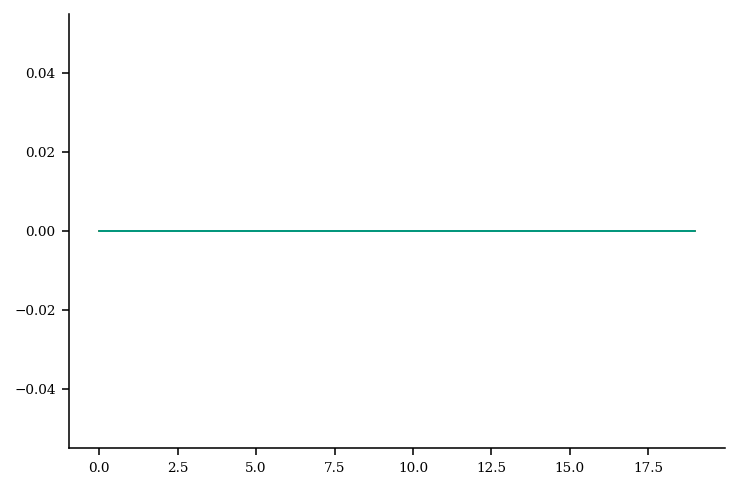

In [25]:
plt.plot((J_field['J^theta'][axn]*cov_basis['e_theta'][:,axn]).T,lw=1);

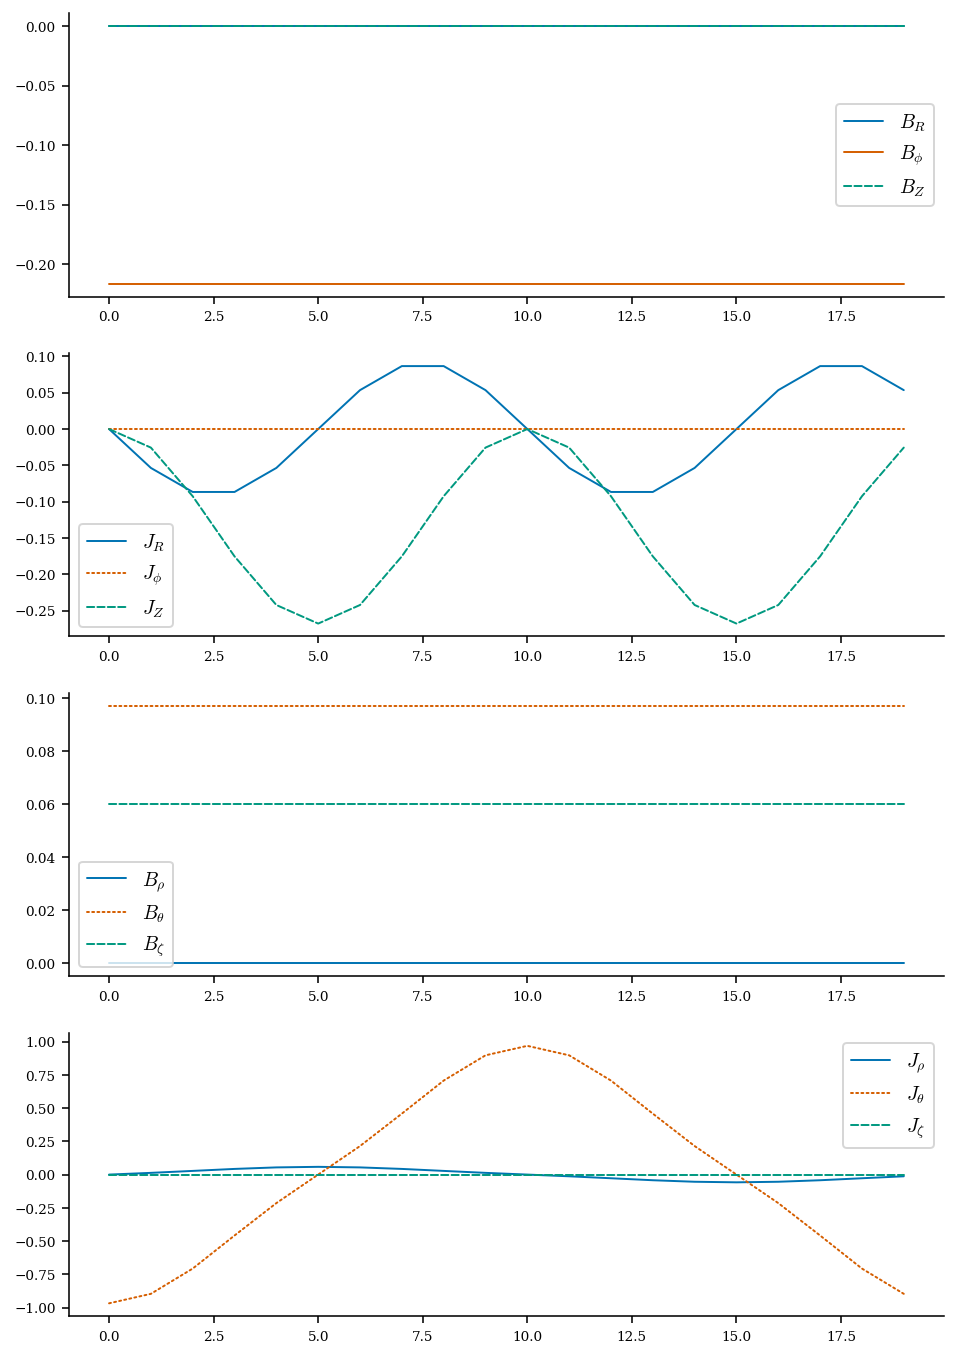

In [26]:
B = B_field['B^zeta']*cov_basis['e_zeta'] + B_field['B^theta']*cov_basis['e_theta'] \
    + B_field['B^rho']*cov_basis['e_rho']
# J = J_field['J^zeta']*cov_basis['e_zeta'] + J_field['J^theta']*cov_basis['e_theta'] \
#     + J_field['J^rho']*cov_basis['e_rho']
J = J_field['J^zeta']*cov_basis['e_zeta'] \
    + J_field['J^rho']*cov_basis['e_rho']

fig, ax = plt.subplots(4, figsize=(8,12))

ax[0].plot(B[0][axn],lw=1,label='$B_R$')
ax[0].plot(B[1][axn],lw=1,label='$B_\\phi$')
ax[0].plot(B[2][axn],lw=1,ls='--',label='$B_Z$')
ax[0].legend()
ax[1].plot(J[0][axn],lw=1,label='$J_R$')
ax[1].plot(J[1][axn],lw=1,ls=':',label='$J_\\phi$')
ax[1].plot(J[2][axn],lw=1,ls='--',label='$J_Z$')
ax[1].legend()
ax[2].plot(B_field['B^rho'][axn],lw=1,label='$B_\\rho$')
ax[2].plot(B_field['B^theta'][axn],lw=1,ls=':',label='$B_\\theta$')
ax[2].plot(B_field['B^zeta'][axn],lw=1,ls='--',label='$B_\zeta$')
ax[2].legend()
ax[3].plot(J_field['J^rho'][axn]*helical[axn],lw=1,label='$J_\\rho$')
ax[3].plot(J_field['J^theta'][axn]*radial[axn],lw=1,ls=':',label='$J_\\theta$')
ax[3].plot(J_field['J^zeta'][axn]*radial[axn],lw=1,ls='--',label='$J_\zeta$')
ax[3].legend()

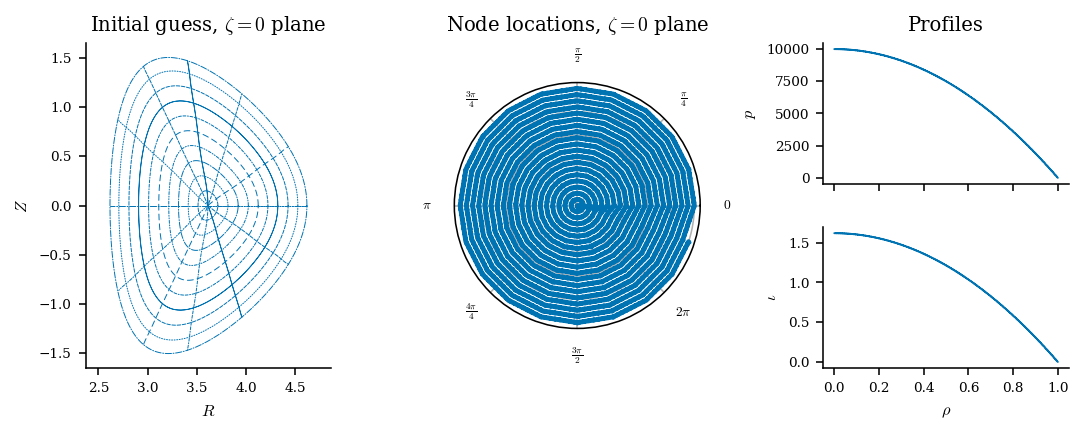

In [15]:
# Inputs
Psi_total = 1
M = 6
N = 0
NFP = 1
zern_idx = get_zern_basis_idx_dense(M,N)
lambda_idx = get_double_four_basis_idx_dense(M,N)

# profiles, polynomial basis
p0 = 1e4
pressfun_params = (p0,0,-p0)
iota0 = 1.618
iotafun_params = (iota0,0,-iota0)


# Node locations
r = np.linspace(0.,1,20)
dr = np.diff(r)[0]
v = np.linspace(0,2*jnp.pi,21)[:-1]
dv = np.diff(v)[0]
# z = np.linspace(0,2*np.pi/NFP,N*)
dz = 2*np.pi/NFP
rr,vv = np.meshgrid(r,v,indexing='ij')
rr = rr.flatten()
vv = vv.flatten()
zz = np.zeros_like(rr)
nodes = np.stack([rr,vv,zz])
dr = dr*np.ones_like(rr)
dv = dv*np.ones_like(vv)
dz = dz*np.ones_like(zz)
volumes = np.stack([dr,dv,dz])
axn = np.where(rr == 0)[0]

# interpolator
derivatives = get_needed_derivatives('force')
zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)


# Boundary Shape as fourier series
bdry_mode = 'spectral'
bdryM = jnp.arange(-M,M+1)
bdryN = jnp.arange(-N,N+1)
bdryM, bdryN = jnp.meshgrid(bdryM, bdryN, indexing='ij')
bdryM = bdryM.flatten()
bdryN = bdryN.flatten()
bdryR = jnp.zeros(len(bdryM),dtype=jnp.float64)
bdryZ = jnp.zeros(len(bdryM),dtype=jnp.float64)

# bndryR = [0.000; 0.00; 3.51; -1.00; 0.106];
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 0, bdryN == 0))[0], 3.51)
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 1, bdryN == 0))[0], -1.0)
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 2, bdryN == 0))[0], 0.106)
#bndryZ = [0.160; 1.47; 0.00;  0.00; 0.000];
bdryZ = put(bdryZ, jnp.where(jnp.logical_and(bdryM == -2, bdryN == 0))[0], 0.160)
bdryZ = put(bdryZ, jnp.where(jnp.logical_and(bdryM == -1, bdryN == 0))[0], 1.47)

bdry_poloidal = bdryM
bdry_toroidal = bdryN

# # Boundary shape in real space
# bdry_mode = 'real'
# bdry_theta = np.linspace(0,2*np.pi,101)
# bdry_psi = np.zeros_like(bdry_theta)
# b = 1
# a = 1
# R0 = 2
# Z0 = 0
# bdryR = R0 + b*np.cos(bdry_theta)
# bdryZ = Z0 + a*np.sin(bdry_theta)
# bdry_poloidal = bdry_theta
# bdry_toroidal = bdry_psi





# initial guess
cR_init,cZ_init = get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_poloidal,bdry_toroidal,zern_idx,NFP,mode=bdry_mode,nr=20,rcond=1e-6)
cL_init = np.zeros(len(lambda_idx))
x_init = np.concatenate([cR_init,cZ_init,cL_init])

# weights
weights = {'F':1e6,     # force balance error
           'R':1e4,     # error in R component of bdry
           'Z':1e4,     # error in Z component of bdry
           'L':1e4}     # error in sum lambda_mn


nodes = jnp.asarray(nodes)
volumes = jnp.asarray(volumes)

args = (zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,
        volumes,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights)


fig, ax = plot_IC(cR_init, cZ_init, zern_idx, NFP, nodes, pressfun_params, iotafun_params)


In [16]:
if bdry_mode == 'real':
    bdry_fun = compute_bc_err_RZ
elif bdry_mode == 'spectral':
    bdry_fun = compute_bc_err_four

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def lstsq_obj(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
              Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):
    
    cR,cZ,cL = unpack_x(x,zern_idx)
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    errR,errZ = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL = compute_lambda_err(cL,lambda_idx,NFP)
    # divide through by size of the array so weighting isn't thrown off by more points
    loss = jnp.concatenate([weights['F']*errF.flatten()/errF.size,   
                           weights['R']*errR.flatten()/errR.size,
                           weights['Z']*errZ.flatten()/errZ.size,
                           weights['L']*errL.flatten()/errL.size])
    return loss

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def force_obj(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
              Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):

    cR,cZ,cL = unpack_x(x,zern_idx)
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    return rms(errF)

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def bc_constraint_fun(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
                      Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):

    cR,cZ,cL = unpack_x(x,zern_idx)
    errR,errZ = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    err = jnp.concatenate([errR,errZ])
    return jnp.array([rms(errR), rms(errZ)])

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def lambda_constraint_fun(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
                          Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):

    cR,cZ,cL = unpack_x(x,zern_idx)
    errL = compute_lambda_err(cL,lambda_idx,NFP)

    return errL

class FiniteDifferenceJacobian():
    def __init__(self, fun, rel_step=jnp.finfo(jnp.float64).eps**(1/3)):
        self.fun = fun
        self.rel_step = rel_step
    @conditional_decorator(functools.partial(jit,static_argnums=np.arange(0,2)), use_jax)
    def __call__(self,x0,*args):
        f0 = self.fun(x0,*args)
        m = f0.size
        n = x0.size
        J_transposed = jnp.empty((n, m))
        idx = jnp.arange(m).astype(jnp.int64)
        sign_x0 = (x0 >= 0).astype(float) * 2 - 1
        h = self.rel_step * sign_x0 * jnp.maximum(1.0, jnp.abs(x0))
        h_vecs = jnp.diag(h)
        for i in range(h.size):
            x1 = x0 - h_vecs[i]
            x2 = x0 + h_vecs[i]
            dx = x2[i] - x1[i]
            f1 = self.fun(x1,*args)
            f2 = self.fun(x2,*args)
            df = f2 - f1
            dfdx = df / dx
            put(J_transposed,i*m+idx,dfdx)
        if m == 1:
            J_transposed = jnp.ravel(J_transposed)
        return J_transposed.T
    
def callback(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
             Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):
    
    cR,cZ,cL = unpack_x(x,zern_idx)
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    errR,errZ = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL = compute_lambda_err(cL,lambda_idx,NFP)

    errFrms = rms(errF)
    errRrms = rms(errR)
    errZrms = rms(errZ)    
    errLrms = rms(errL)
    
    loss = np.concatenate([weights['F']*errF.flatten(),
                           weights['R']*errR.flatten(),
                           weights['Z']*errZ.flatten(),
                           weights['L']*errL.flatten()])
    lossrms = rms(loss)    
    print('Weighted Loss: {:10.3e}  errF: {:10.3e}  errBdryR: {:10.3e}  errBdryZ: {:10.3e}  errLambda: {:10.3e}'.format(
    lossrms,errFrms,errRrms,errZrms,errLrms))

In [17]:
lstsq_obj = jit(lstsq_obj, static_argnums=np.arange(len(args))+1)
jac = jit(jacfwd(lstsq_obj),static_argnums=np.arange(len(args))+1)

In [18]:
callback(x_init,*args)

Weighted Loss:  3.052e+09  errF:  3.103e+03  errBdryR:  2.196e-04  errBdryZ:  3.238e-04  errLambda:  0.000e+00


In [32]:
%%timeit
cost = lstsq_obj(x_init,*args).block_until_ready() 

31.4 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [271]:
%%timeit
foo = jac(x_init,*args).block_until_ready() 

32 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
x1 = x_init #+ .001*np.random.normal(size=x_init.size)
callback(x1)
out = scipy.optimize.least_squares(lstsq_obj,
                                   x1,
                                   args=args,
                                   jac=jac if use_jax else None,
                                   x_scale='jac',
                                   ftol=1e-10, 
                                   xtol=1e-8, 
                                   gtol=1e-8, 
                                   max_nfev=1000, 
                                   verbose=2)
x = out['x']

Loss:  3.095e+04  errF:  3.146e-02  errR:  2.196e-04  errZ:  3.238e-04  errL:  0.000e+00
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1870e+05                                    4.83e+08    
       1              3         4.1576e+04      5.77e+05       2.64e-01       4.46e+07    
       2              4         8.3059e+03      3.33e+04       1.58e-01       2.92e+07    
       3              5         8.1860e+02      7.49e+03       1.07e-01       5.44e+06    
       4              7         2.8088e+02      5.38e+02       9.78e-02       2.66e+06    
       5              9         6.9773e+01      2.11e+02       2.04e-02       5.72e+05    
       6             11         6.5503e+01      4.27e+00       1.03e-02       4.48e+04    
       7             13         6.4713e+01      7.90e-01       5.28e-03       1.36e+04    
       8             14         6.3739e+01      9.74e-01       1.08e-02       4.84e+04    
 

In [65]:
print('Initial')
callback(x_init, *args)
print('Final')
callback(x, *args)

Initial
Weighted Loss:  3.095e+04  errF:  3.146e-02  errBdryR:  2.196e-04  errBdryZ:  3.238e-04  errLambda:  0.000e+00
Final
Weighted Loss:  2.955e+02  errF:  3.004e-04  errBdryR:  1.224e-04  errBdryZ:  1.029e-04  errLambda:  3.744e-08


In [89]:
R0, Z0 = axis_posn(cR,cZ,zern_idx,NFP)
'{:10.3e} {:10.3e}'.format(R0,Z0)

' 3.605e+00  6.185e-02'

(array([3.60542809]), array([0.06185332]))


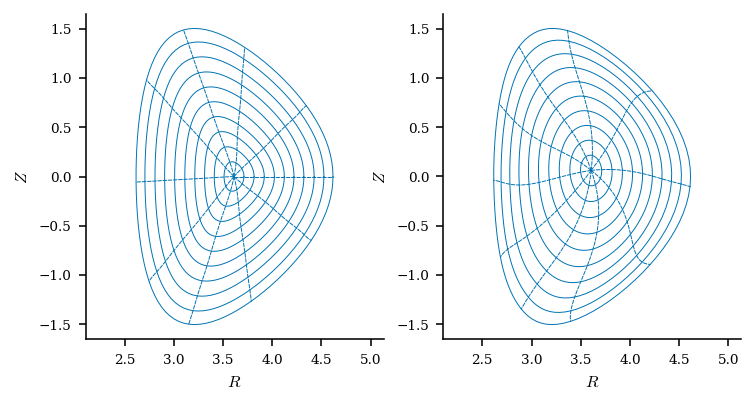

In [41]:
x = out['x']
cR,cZ,cL = unpack_x(x,zern_idx)
print(axis_posn(cR,cZ,zern_idx,NFP))

fig, ax = plt.subplots(1,2,figsize=(6,3))
plot_coord_surfaces(cR_init,cZ_init,zern_idx,NFP,nr=10,ntheta=10,ax=ax[0])
plot_coord_surfaces(cR,cZ,zern_idx,NFP,nr=10,ntheta=10,ax=ax[1])

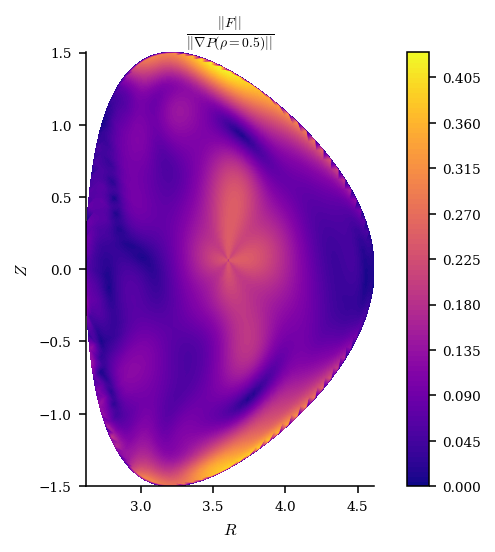

In [83]:
fig, ax = plt.subplots()
ax, im = plot_fb_err(cR,cZ,cL,zern_idx,lambda_idx,NFP,iotafun_params, pressfun_params, Psi_total,
                domain='real', normalize='global', ax=ax, log=False, cmap='plasma')
plt.colorbar(im)

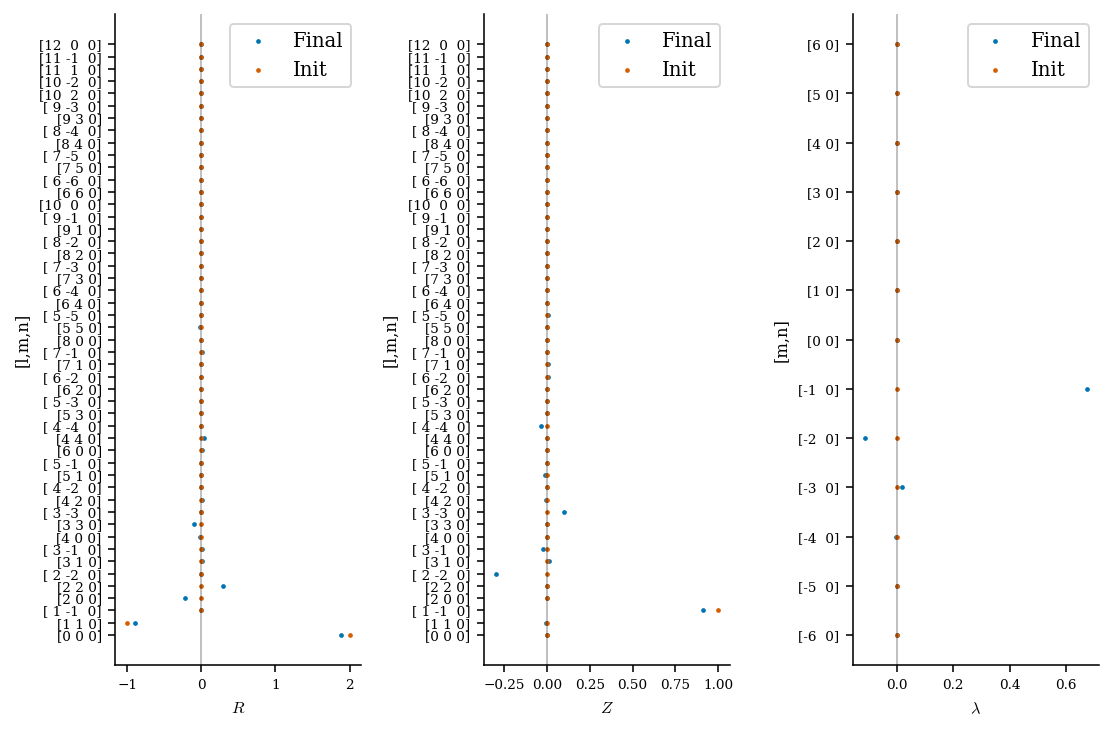

In [223]:
plot_coeffs(cR,cZ,cL,zern_idx,lambda_idx,cR_init,cZ_init,cL_init);

In [58]:
force_obj = jit(force_obj, static_argnums=np.arange(1,15))
force_jac = jit(jax.jacfwd(force_obj),static_argnums=np.arange(1,15))
bc_constraint_fun = jit(bc_constraint_fun, static_argnums=np.arange(1,15))
bc_jac = jit(jax.jacfwd(bc_constraint_fun),static_argnums=np.arange(1,15))

force_obj(x_init,*args).block_until_ready();
force_jac(x_init,*args).block_until_ready();
bc_constraint_fun(x_init,*args).block_until_ready();
bc_jac(x_init,*args).block_until_ready();

In [59]:
callback(x_init)

# slsqp_constraints=[{'type':'eq',
#                     'fun':lambda_constraint_fun,
#                     'jac':lambda_jac if use_jax else None,
#                     'args': args},
#                    {'type':'eq',
#                     'fun':bc_constraint_fun,
#                     'jac':bc_jac if use_jax else None,
#                     'args': args}]

trf_constraints = [scipy.optimize.NonlinearConstraint(lambda x: bc_constraint_fun(x,*args), 
                                                      -1e-3, 
                                                      1e-3, 
                                                      jac=lambda x: bc_jac(x,*args), 
                                                      keep_feasible=False, 
                                                      ),
                   scipy.optimize.LinearConstraint(get_lambda_constraint_matrix(M,N,NFP), 0, 0)
                  ]

# out = scipy.optimize.minimize(force_obj,
#                               x_init,
#                               args=args,
#                               method='SLSQP',
#                               jac=force_jac if use_jax else None,
#                               options={'disp':True,
#                                        'maxiter':500},
#                               constraints=slsqp_constraints,
#                               callback=callback
#                              )

out = scipy.optimize.minimize(force_obj,
                              x_init,
                              args=args,
                              method='trust-constr',
                              jac=force_jac if use_jax else None,
                              options={'disp':True,
                                       'maxiter':5000},
                              constraints=trf_constraints,
#                               callback=callback
                             )

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
The maximum number of function evaluations is exceeded.
Number of iterations: 5001, function evaluations: 5001, CG iterations: 5197, optimality: 2.50e-01, constraint violation: 1.05e-07, execution time: 7.9e+01 s.


In [60]:
callback(x_init)
callback(out['x'])

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
Loss:  1.259e+04  errF:  1.544e-02  errR:  2.934e-06  errZ:  2.339e-06  errL:  1.052e-07


In [90]:
def DESC_to_gfile(cR,cZ,iotafun_params,pressfun_params,Psi_total,M,N,NFP,nw=65,nh=65,nr=50,ntheta=50,npsi=1000, 
                  rdim=None,zdim=None,rleft=None,rcentr=None,zmid=None,axis_flux=0):

    g = {}
    g['date']=pytime.localtime()
    g['shot']=0
    g['time']=0
    g['efit']='DESC'
    g['nw']=nw
    g['nh']=nh


    # get poloidal flux (psi) as function of toroidal flux (rho)
    efitPsi = np.linspace(0,1,g['nw'])
    rho_n = np.linspace(1e-3,1,npsi)
    rho = 2*Psi_total*rho_n
    iota = iotafun(rho_n)
    psi = scipy.integrate.cumtrapz(rho*iota,rho_n,initial=axis_flux)
    psi_n = (psi - np.min(psi))/(np.max(psi)-np.min(psi))
    psi_n_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi_n)
    psi_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi)
    rho_n_of_psi_n = scipy.interpolate.CubicSpline(psi_n,rho_n)

    # get Bt
    vv = np.zeros_like(rho_n)
    zz = np.zeros_like(rho_n)
    nodes = np.stack([rho_n,vv,zz])
    axn = np.where(nodes[0]==0)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)
    coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
    cov_basis = compute_covariant_basis(coord_der)
    jacobian = compute_jacobian(coord_der,cov_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
    R = zernt.transform(cR,0,0,0).flatten()
    B = B_field['B^theta']*cov_basis['e_theta'] + B_field['B^zeta']*cov_basis['e_zeta']
    Bt = B[1]
    g['bcentr'] = np.linalg.norm(B[:,0])

    # compute profiles
    Fpol = scipy.interpolate.CubicSpline(rho_n,R*Bt)
    g['fpol'] = Fpol(rho_n_of_psi_n(efitPsi))
    g['ffprime'] = Fpol(rho_n_of_psi_n(efitPsi))*Fpol(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    g['pres'] = pressfun(rho_n_of_psi_n(efitPsi))
    g['pprime'] = pressfun(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    iotapsi = iotafun(rho_n_of_psi_n(efitPsi))
    qidx = np.where(iotapsi != 0)[0]
    g['qpsi'] = scipy.interpolate.CubicSpline(efitPsi[qidx],1/iotapsi[qidx])(efitPsi)


    # compute psi(R,Z)
    r = np.linspace(0,1,nr)
    v = np.linspace(0,2*np.pi,ntheta)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    rr = rr.flatten()
    vv = vv.flatten()
    zz = np.zeros_like(rr)
    nodes = np.stack([rr,vv,zz])
    axn = np.where(rr==0)[0]
    bdryn = np.where(rr==1)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)

    R = zernt.transform(cR,0,0,0).flatten()
    Z = zernt.transform(cZ,0,0,0).flatten()
    psiRZ = psi_of_rho_n(rr)

    g['rmaxis'] = np.mean(R[axn])
    g['zmaxis'] = np.mean(Z[axn])
    g['nbbbs'] = bdryn.size
    g['rbbbs'] = R[bdryn]
    g['zbbbs'] = Z[bdryn]
    g['axis_flux'] = np.mean(psiRZ[axn])
    g['boundary_flux'] = np.mean(psiRZ[bdryn])

    g['rdim'] = rdim if rdim else (np.max(R)-np.min(R))*1.5
    g['rcentr'] = rcentr if rcentr else (np.max(R)+np.min(R))/2
    g['zdim'] = zdim if zdim else (np.max(Z)-np.min(Z))*1.5
    g['zmid'] = zmid if zmid else (np.max(Z)+np.min(Z))/2
    g['rleft'] = rleft if rleft else g['rcentr'] - g['rdim']/2

    efitR = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
    efitZ = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
    efitRR,efitZZ = np.meshgrid(efitR,efitZ,indexing='ij')

    g['psirz'] = scipy.interpolate.griddata((R,Z),psiRZ,(efitRR,efitZZ),method='cubic').T
    g['psirz'][np.isnan(g['psirz'])] = g['boundary_flux']

    g['limitr'] = 0
    g['rlimitr'] = np.array([])
    g['zlimitr'] = np.array([])
    
    return g

In [91]:
plot_gfile(DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP))

TypeError: iotafun() missing 2 required positional arguments: 'nu' and 'params'

In [60]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt, fraction

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
BR = Function('B_\\rho', real=True)(rho,theta,zeta)
BT = Function('B_\\theta', real=True)(rho,theta,zeta)
BZ = Function('B_\\zeta', real=True)(rho,theta,zeta)



R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

g = e_t.cross(e_z).dot(e_r)

JR = (BZ.diff(theta) - BT.diff(zeta))/g
JT = (BR.diff(zeta) - BZ.diff(rho))/g
JZ = (BT.diff(rho) - BR.diff(theta))/g

J = JR*e_r + JT*e_t + JZ*e_z
# J = simplify(J)


In [64]:
fraction(simplify(J)[0])[0]

-(Derivative(B_\rho(\rho, \theta, \zeta), \theta) - Derivative(B_\theta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \zeta) + (Derivative(B_\rho(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \theta) - (Derivative(B_\theta(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \theta))*Derivative(R(\rho, \theta, \zeta), \rho)

In [62]:
simplify(J)[0]

(-(Derivative(B_\rho(\rho, \theta, \zeta), \theta) - Derivative(B_\theta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \zeta) + (Derivative(B_\rho(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \theta) - (Derivative(B_\theta(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \theta))*Derivative(R(\rho, \theta, \zeta), \rho))/((Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*R(\rho, \theta, \zeta))

In [33]:
B_field.keys()

dict_keys(['B^rho', 'B^theta', 'B^zeta', 'B^zeta_r', 'B^zeta_rv', 'B^zeta_v', 'B^zeta_z', 'B_rho_v', 'B_rho_z', 'B_theta_r', 'B_theta_z', 'B_theta_zr', 'B_zeta_r', 'B_zeta_rv', 'B_zeta_v', 'psi', 'psi_r', 'psi_rr'])

In [34]:
coord_der.keys()

dict_keys(['0', 'R', 'R_r', 'R_rr', 'R_rrv', 'R_rrvv', 'R_rv', 'R_rvv', 'R_rz', 'R_v', 'R_vr', 'R_vv', 'R_vz', 'R_z', 'R_zr', 'R_zrv', 'R_zv', 'R_zz', 'Z', 'Z_r', 'Z_rr', 'Z_rrv', 'Z_rrvv', 'Z_rv', 'Z_rvv', 'Z_rz', 'Z_v', 'Z_vr', 'Z_vv', 'Z_vz', 'Z_z', 'Z_zr', 'Z_zrv', 'Z_zv', 'Z_zz'])

In [47]:
num = (-(B_field['B_rho_v'] - B_field['B_theta_r'])*coord_der['R_z'] + (B_field['B_rho_z'] 
                    - B_field['B_zeta_r'])*coord_der['R_v'] - (B_field['B_theta_z'] - B_field['B_zeta_v'])*coord_der['R_r'])
den = (coord_der['R_r']*coord_der['Z_v'] - coord_der['R_v']*coord_der['Z_r'])*coord_der['R']

dden = (coord_der['R_rr']*coord_der['Z_v'] + coord_der['R_r']*coord_der['Z_rv']
        - coord_der['R_rv']*coord_der['Z_r'] - coord_der['R_v']*coord_der['Z_rr'])*coord_der['R'] + (coord_der['R_r']*coord_der['Z_v'] - coord_der['R_v']*coord_der['Z_r'])*coord_der['R_r']

In [48]:
dden

DeviceArray([  5.30902191,   5.30902191,   5.30902191,   5.30902191,
               5.30902191,   5.30902191,   5.30902191,   5.30902191,
               5.30902191,   5.30902191,   5.30902191,   5.30902191,
               5.30902191,   5.30902191,   5.30902191,   5.30902191,
               5.30902191,   5.30902191,   5.30902191,   5.30902191,
               4.92808523,   4.94272652,   4.98373542,   5.04489781,
               5.12174166,   5.2138493 ,   5.3214884 ,   5.43885888,
               5.54984446,   5.63094235,   5.66084461,   5.63094235,
               5.54984446,   5.43885888,   5.3214884 ,   5.2138493 ,
               5.12174166,   5.04489781,   4.98373542,   4.94272652,
               4.60617492,   4.64645171,   4.74191132,   4.84076106,
               4.91465125,   4.98694951,   5.11214224,   5.32241553,
               5.58565121,   5.81070977,   5.89968818,   5.81070977,
               5.58565121,   5.32241553,   5.11214224,   4.98694951,
               4.91465125,   4.840

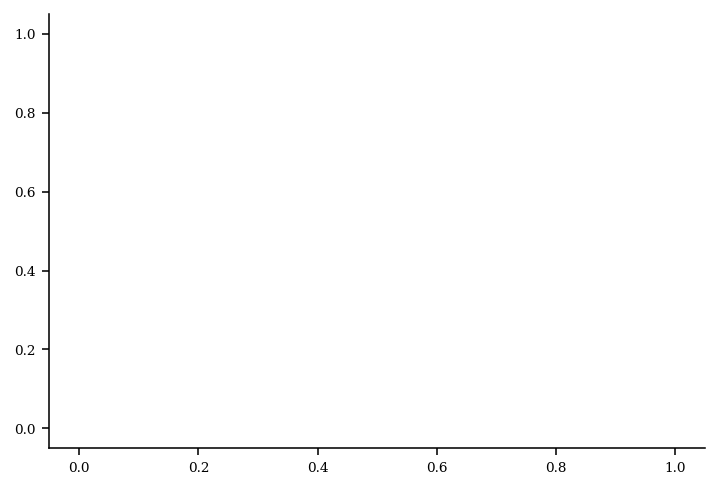

In [40]:
plt.plot(J_field['J_R'][axn],lw=1)

In [103]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt
from sympy.vector import CoordSys3D, curl, gradient, divergence

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
X = Matrix([rho,theta,zeta])
R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)
dR = Function('{\delta}R')(rho,theta,zeta)
dZ = Function('{\delta}Z')(rho,theta,zeta)
xi_R = Function('\\xi_R')(rho,theta,zeta)
xi_P = Function('\\xi_\\phi')(rho,theta,zeta)
xi_Z = Function('\\xi_Z')(rho,theta,zeta)


xi = Matrix([xi_R,xi_P,xi_Z])

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

de_r = Matrix([dR.diff(rho),   0,  dZ.diff(rho)])
de_t = Matrix([dR.diff(theta), 0,  dZ.diff(theta)])
de_z = Matrix([dR.diff(zeta),  dR, dZ.diff(zeta)])

psi_a = symbols("psi_a")
iota = Function('\iota')(rho)
pres = Function('p')(rho)
psi = psi_a*rho**2
psi = Function('\\Psi')(rho)
covG = eye(3)
conG = eye(3)
covE = Matrix([e_r.T,e_t.T,e_z.T]).T
covE = simplify(covE)

g = e_t.cross(e_z).dot(e_r)
eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

conE = Matrix([eR.T,eT.T,eZ.T]).T
conE = simplify(conE)

for i in range(3):
    for j in range(3):
        covG[i,j] = covE[:,i].dot(covE[:,j])
        conG[i,j] = conE[:,i].dot(conE[:,j])

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ





# conB = Matrix([0,BT,BZ])
# conB = simplify(conB)

# covB = covG*conB
# covB = simplify(covB)

# conJ = zeros(3,1)

# for i in range(3):
#     for j in range(3):
#         conJ += covB[j].diff(X[i])*conE[:,i].cross(conE[:,j])

# # conJ = simplify(conJ)

# B = BZ*e_z + BT*e_t
# J = covE*conJ

# JxB = J.cross(B)

In [76]:
g = Function('g')(rho,theta,zeta)
g = sqrt(g)
b_r = Function('b_\\rho')(rho,theta,zeta)
b_t = Function('b_\\theta')(rho,theta,zeta)
b_z = Function('b_\\zeta')(rho,theta,zeta)
b = Matrix([b_r,b_t,b_z])
mu0 = symbols('\mu_0')
coords = Matrix([rho,theta,zeta])
covB = 1/(2*pi*g)*b

JR = 1/(mu0*g)*(covB[2].diff(coords[1]) - covB[1].diff(coords[2]))
JT = 1/(mu0*g)*(covB[0].diff(coords[2]) - covB[2].diff(coords[0]))
JZ = 1/(mu0*g)*(covB[1].diff(coords[0]) - covB[0].diff(coords[1]))
conJ = Matrix([JR,JT,JZ])

eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ

conB = Matrix([0,BT,BZ])

F = g*((JT*BZ - JZ*BT)*eR - JR*BZ*eT + JR*BT*eZ)

In [78]:
simplify(F)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             (-(2*(-Derivative(b_\theta(\rho, \theta, \zeta), \zeta) + Derivative(b_\zeta(\rho, \theta, \zeta), \theta))*g(\rho, \theta, \zeta) + b_\theta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \zeta) - b_\zeta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \theta))*Derivativ

In [104]:
simplify(eZ)

Matrix([
[                        0],
[-1/R(\rho, \theta, \zeta)],
[                        0]])

In [36]:
print(latex(simplify(conG*g**2)))

\left[\begin{matrix}\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)} - \frac{\partial}{\partial \zeta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2}\right) R^{2}{\left(\rho,\theta,\zeta \right)} & - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} + \frac{\partial}{\partial \rho} Z{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right) R^{2}{\left(\rho,\theta,\zeta \right)} - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)

In [74]:
from sympy import symbols, Matrix, diff, pi

er_R, er_P, er_Z = symbols("R_rho phi_rho Z_rho")
ev_R, ev_P, ev_Z = symbols("R_theta phi_theta Z_theta")
ez_R, ez_P, ez_Z = symbols("R_\zeta R Z_\zeta")
psi_a, rho, iota = symbols("psi_a rho iota")

psi = psi_a*rho**2
e_r = Matrix([er_R,0,er_Z])
e_v = Matrix([ev_R,0,ev_Z])
e_z = Matrix([ez_R,ez_P,ez_Z])

g = e_v.cross(e_z).dot(e_r)

erho = e_v.cross(e_z)/g
etheta = e_z.cross(e_r)
ezeta = e_r.cross(e_v)

Bzeta = diff(psi,rho)/(2*pi*g)
Btheta = iota*Bzeta
B = Btheta*etheta + Bzeta*ezeta


beta = Bzeta*etheta - Btheta*ezeta

In [72]:
erho

Matrix([
[                         -R*Z_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[(R_\zeta*Z_theta - R_theta*Z_\zeta)/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[                          R*R_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)]])

In [73]:
beta

Matrix([
[                                                                                                                      R*Z_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[-iota*psi_a*rho*(-R_rho*Z_theta + R_theta*Z_rho)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho)) + psi_a*rho*(-R_\zeta*Z_rho + R_rho*Z_\zeta)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[                                                                                                                     -R*R_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))]])

$$
\begin{align}
\dot{R} &= \frac{\partial R}{\partial t} \\
\dot{\phi} &= \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t}  \\
\dot{Z} &= \frac{\partial Z}{\partial t} \\
\end{align}
$$

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
1 & 0 \\
\frac{\partial \phi}{\partial R} & \frac{\partial \phi}{\partial Z} \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\begin{align}
\ddot{R} &= \frac{\partial^2 R}{\partial t^2} \\
\ddot{\phi} &= \frac{\partial^2 \phi}{\partial R \partial t} \frac{\partial R}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial^2 \phi}{\partial Z \partial t} \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
\ddot{Z} &= \frac{\partial^2 Z}{\partial t^2} \\
\end{align}
$$

$$
\begin{align}
\ddot{\phi} &= \frac{\partial^2 \phi}{\partial R \partial t} \frac{\partial R}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial^2 \phi}{\partial Z \partial t} \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
&= \frac{\partial}{\partial R} \left( \frac{\partial \phi}{\partial t} \right) \frac{\partial R}{\partial t} + \frac{\partial}{\partial Z} \left( \frac{\partial \phi}{\partial t} \right) \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
&= \frac{\partial}{\partial R} \left( \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t} \right) \frac{\partial R}{\partial t} + \frac{\partial}{\partial Z} \left( \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t} \right) \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2}
\end{align}
$$

$$
\vartheta = \pi - \theta + \lambda(\theta,\phi)
$$

In [151]:
r, t, z = symbols(['\\rho','\\theta','\zeta'])
x = Function('x')(r,t,z)
c = Function('c')(r,t,z)
g = Function('g')(x,c)

In [156]:
print(latex(simplify(g.diff(z))))

\frac{\partial}{\partial \zeta} c{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial c{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} + \frac{\partial}{\partial x{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} \frac{\partial}{\partial \zeta} x{\left(\rho,\theta,\zeta \right)}
